<a href="https://colab.research.google.com/github/gobeomgyu/deeplearning/blob/main/WISDM_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from pandas import read_csv, unique
import numpy as np
import pandas as pd

from scipy.stats import mode
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
# %matplotlib inline  # (노트북 환경이면 주석 해제)

import warnings
warnings.filterwarnings("ignore")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# --------------------------------------------------------------------
# 데이터 로드
# --------------------------------------------------------------------

path = '/content/drive/MyDrive/Colab Notebooks/WISDM_ar_v1.1/WISDM_ar_v1.1_raw.txt'

names = ['user-id', 'activity', 'timestamp', 'X', 'Y', 'Z', 'NaN']

data = pd.read_csv(path, header=None, names=names, comment=";", engine="python", on_bad_lines="skip")

In [ ]:
# 세미콜론 제거 + 숫자 변환 (X,Y,Z 전부)
for c in ['X','Y','Z']:
    data[c] = (
        data[c]
        .astype(str)
        .str.strip()
        .str.rstrip(';')
    )
    data[c] = pd.to_numeric(data[c], errors='coerce')

In [ ]:
# 불필요 컬럼 제거 + 결측 제거
df = data.drop(columns=['NaN'])
df.dropna(subset=['X','Y','Z'], inplace=True)

In [ ]:
# 시간순 정렬 (유저-타임스탬프)
# LSTM 같은 순환모델은 입력 순서가 흐트러지면 학습이 엉망

df = df.sort_values(['user-id','timestamp']).reset_index(drop=True)

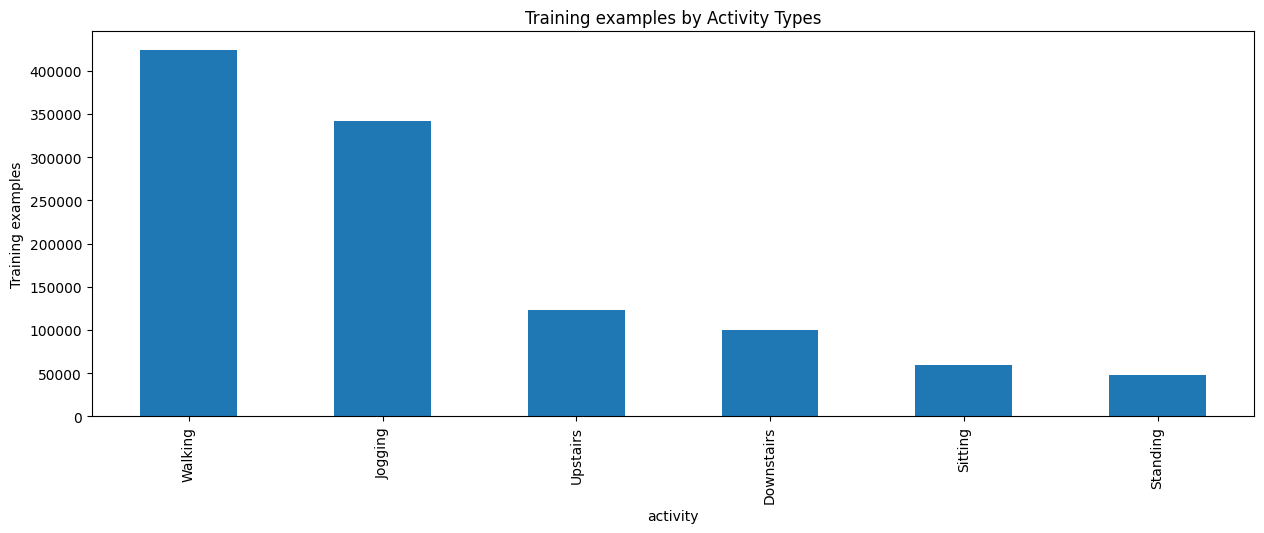

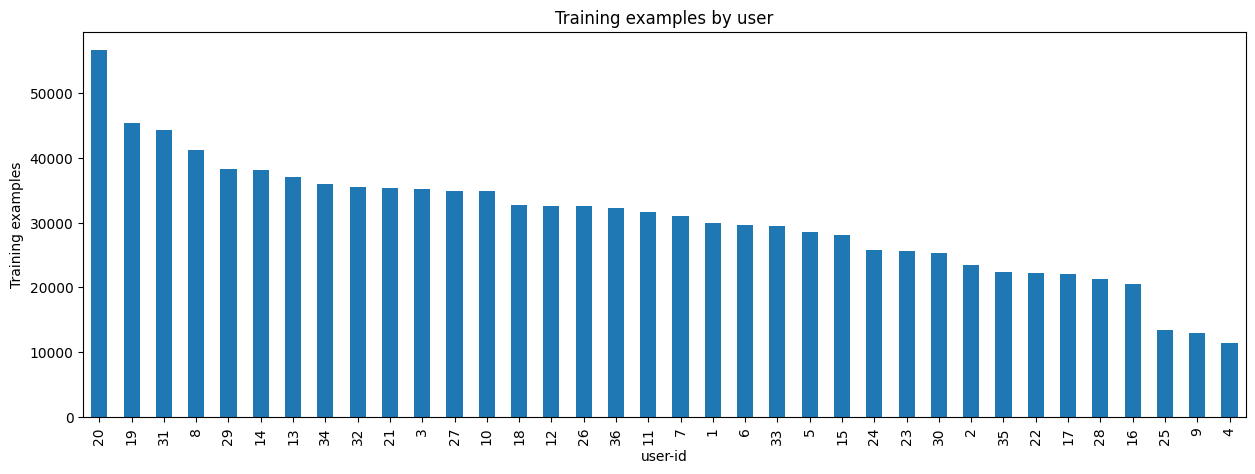

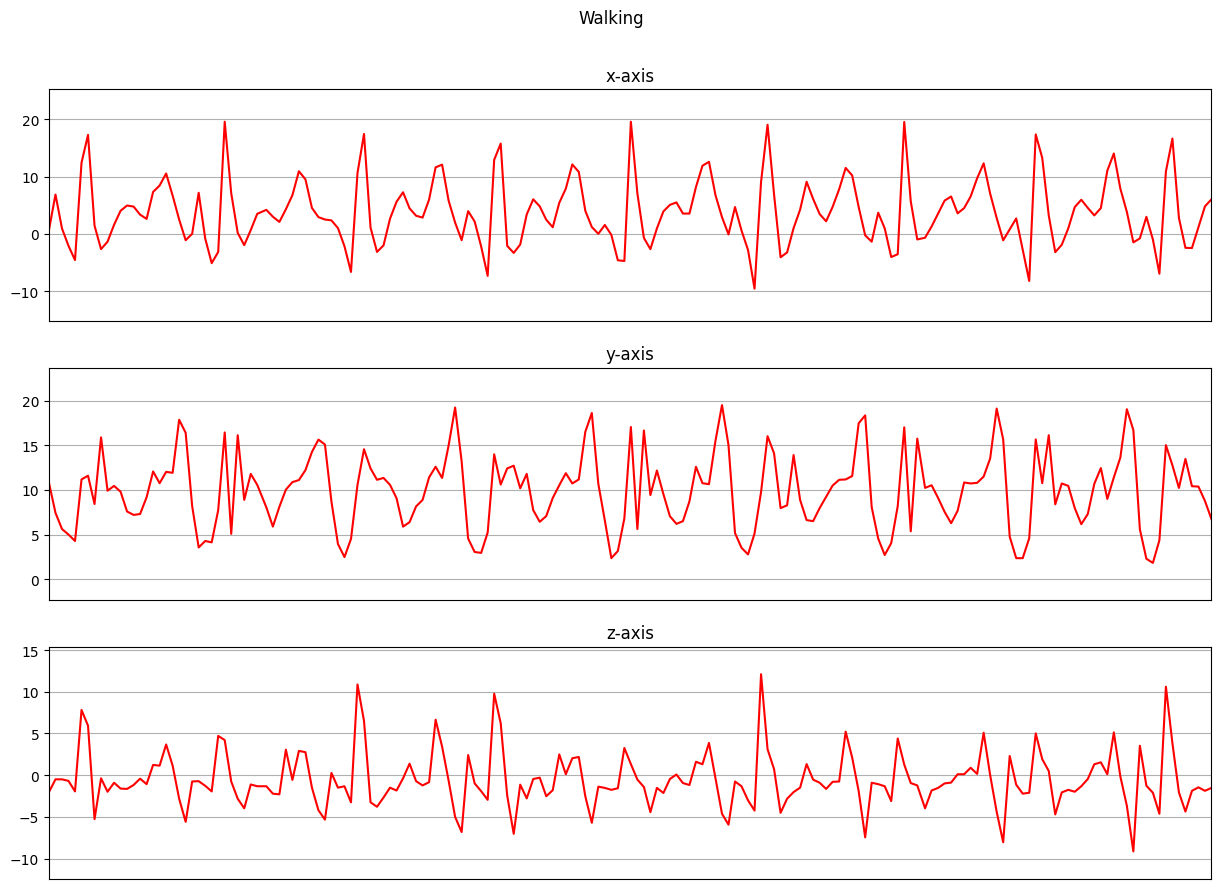

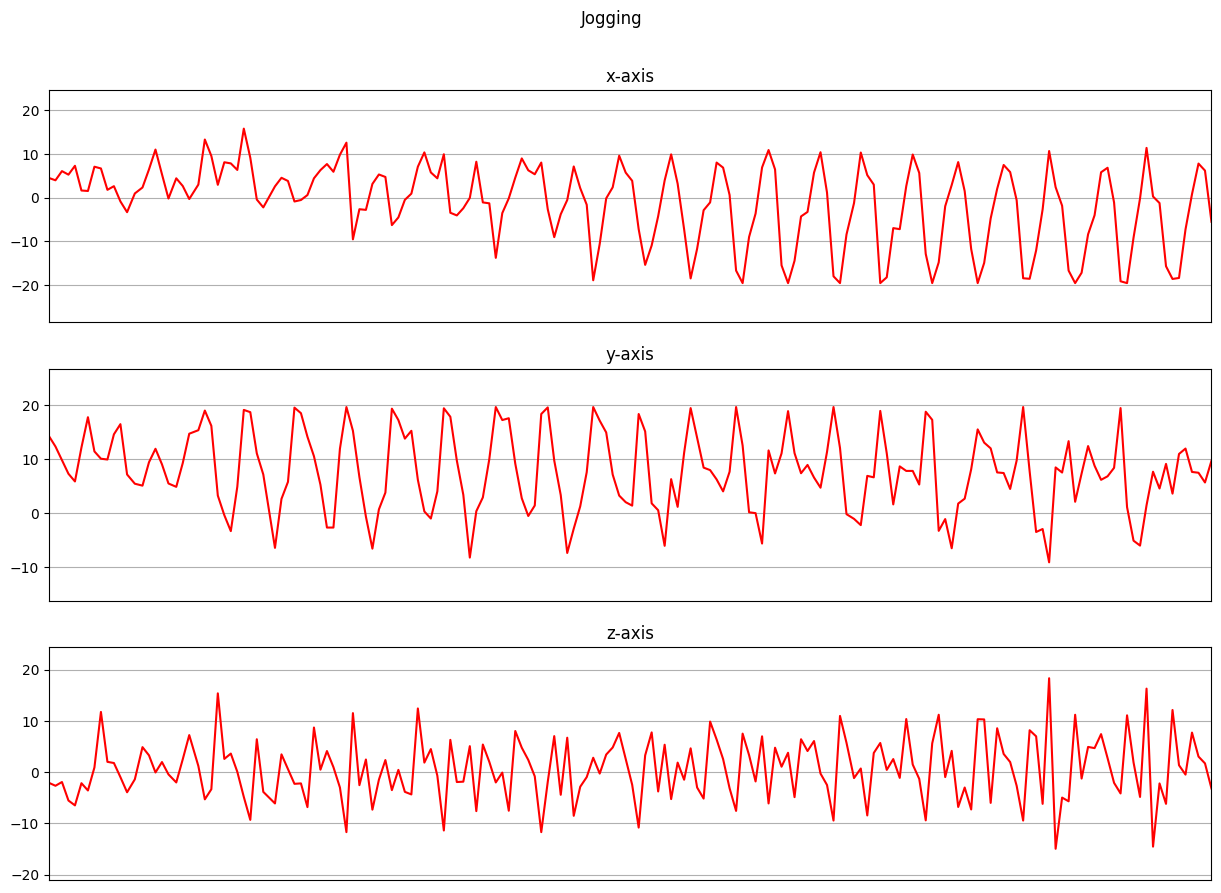

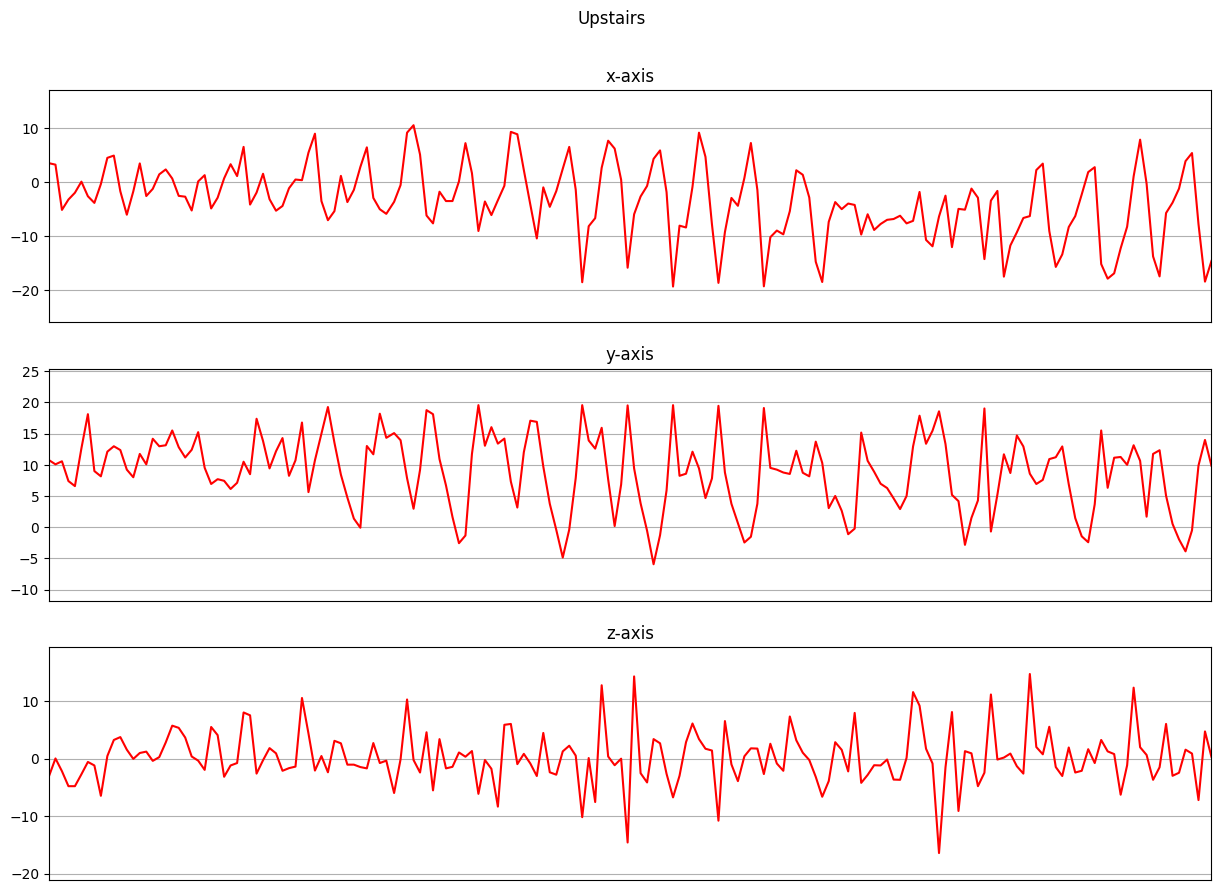

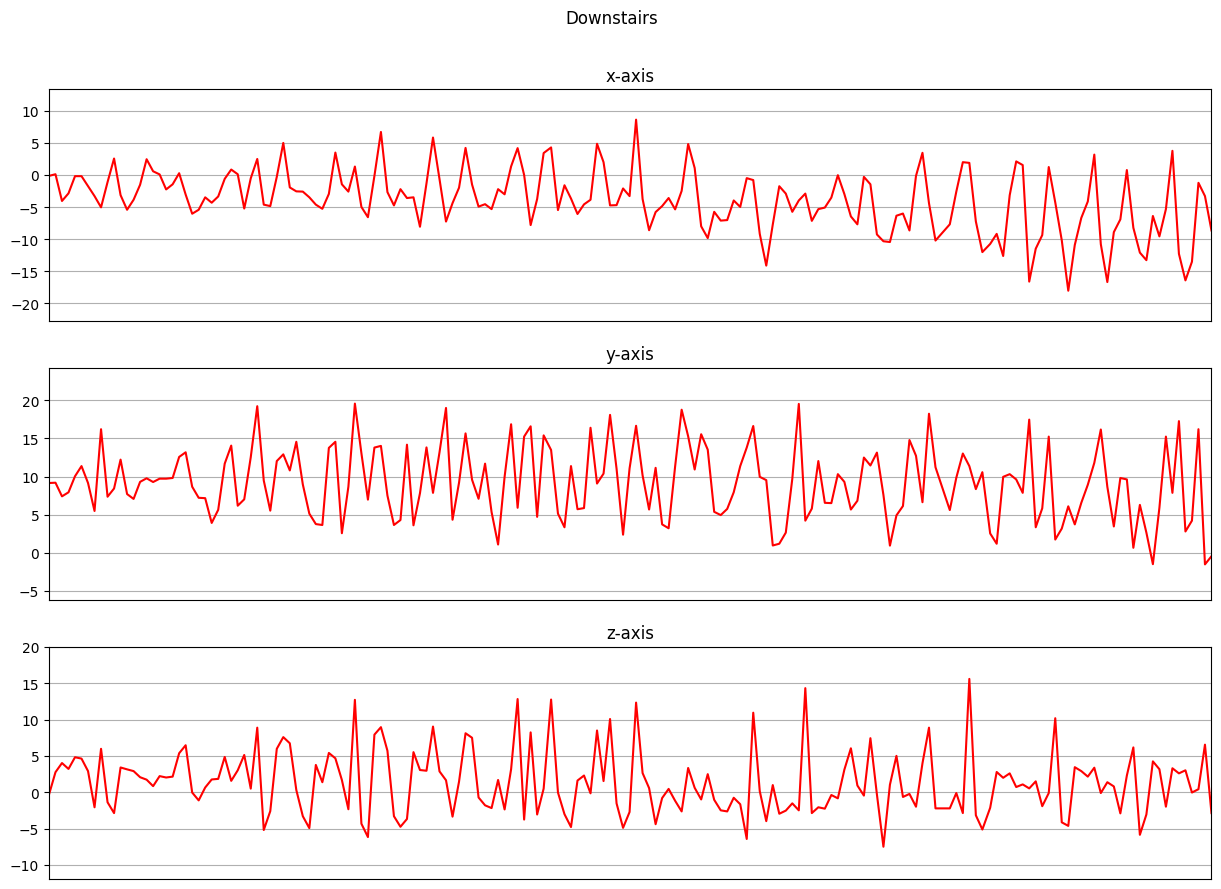

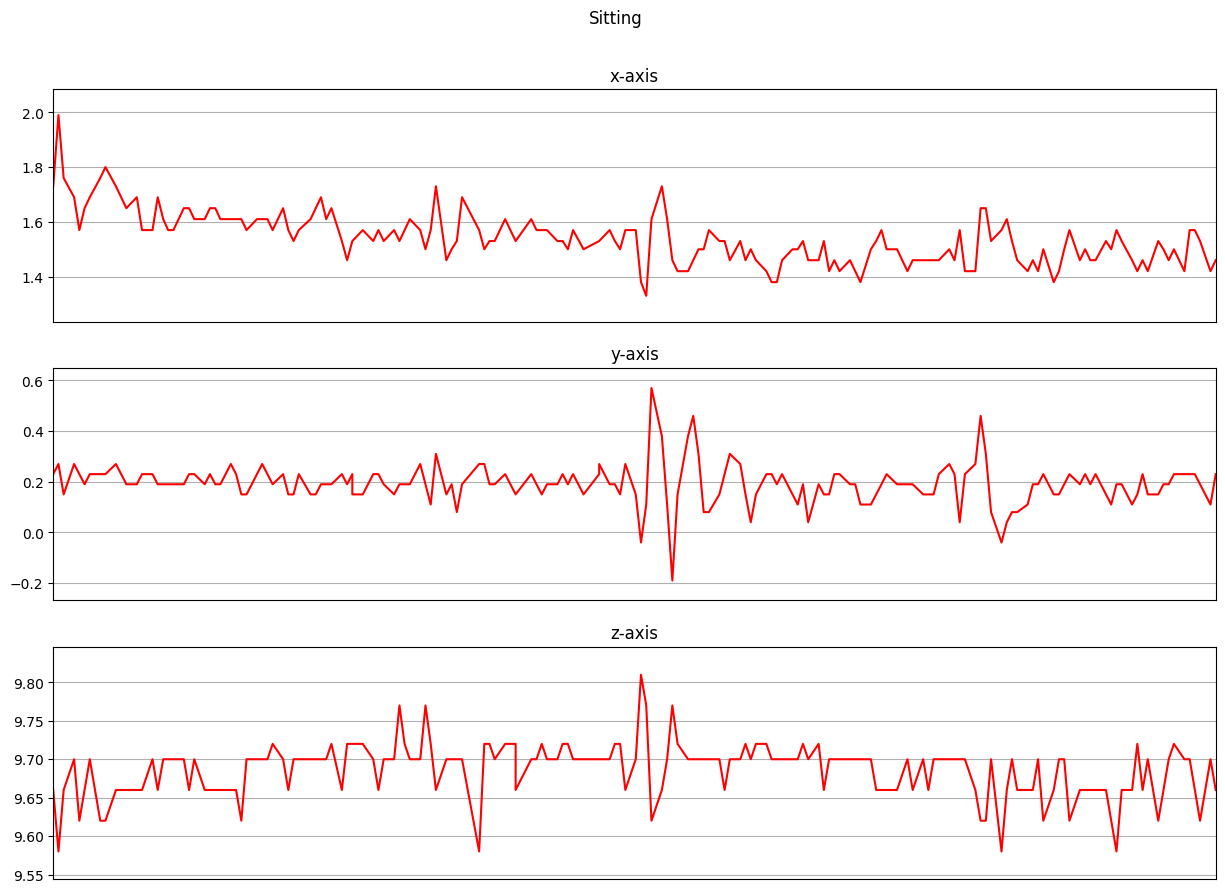

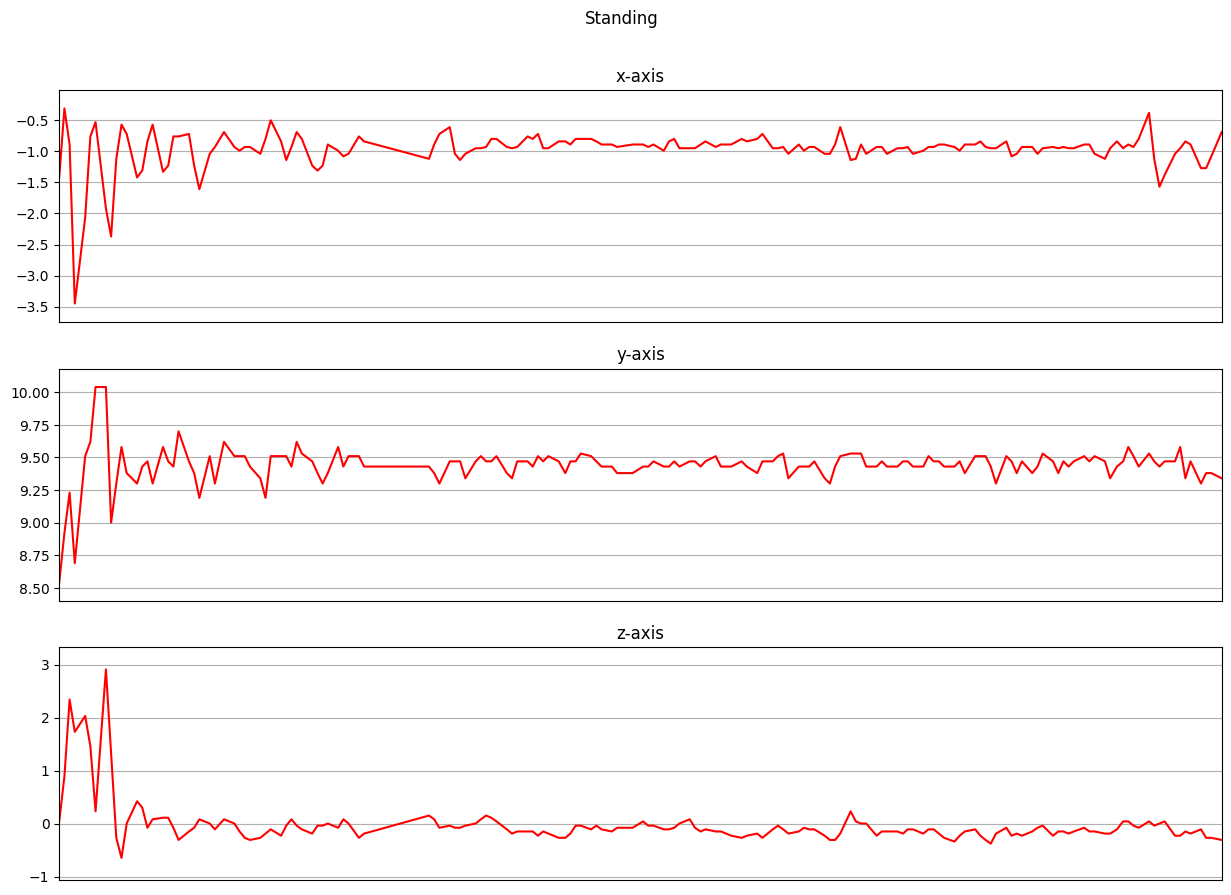

In [ ]:
# EDA(Exploratory Data Analysis, 탐색적 데이터 분석)

plt.figure(figsize=(15, 5))
plt.xlabel('Activity Type')
plt.ylabel('Training examples')
df['activity'].value_counts().plot(kind='bar', title='Training examples by Activity Types')
plt.show()

plt.figure(figsize=(15, 5))
plt.xlabel('User')
plt.ylabel('Training examples')
df['user-id'].value_counts().plot(kind='bar', title='Training examples by user')
plt.show()

def axis_plot(ax, x, y, title):
    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in df['activity'].unique():
    limit = df[df['activity'] == activity].head(180)
    if len(limit) < 2:
        continue
    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3, sharex=True, figsize=(15, 10))
    axis_plot(ax0, limit['timestamp'], limit['X'], 'x-axis')
    axis_plot(ax1, limit['timestamp'], limit['Y'], 'y-axis')
    axis_plot(ax2, limit['timestamp'], limit['Z'], 'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.9)
    plt.show()

In [ ]:
# 라벨 인코딩

label_encode = LabelEncoder()
df['activityEncode'] = label_encode.fit_transform(df['activity'].values.ravel())
print("Classes:", list(label_encode.classes_))


Classes: ['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


In [ ]:
#Train/Test 분리

df_test  = df[df['user-id'] > 27].copy()
df_train = df[df['user-id'] <= 27].copy()

for c in ['X','Y','Z']:
    mn, mx = df_train[c].min(), df_train[c].max()
    scale = (mx - mn) if (mx - mn) != 0 else 1.0
    df_train[c] = (df_train[c] - mn) / scale
    df_test[c]  = (df_test[c]  - mn) / scale

In [ ]:
# 세그먼트 함수

from math import ceil

def segments_grouped(df_in, time_steps, step, label_name):
    N_FEATURES = 3
    segments, labels = [], []
    # 유저-액티비티별로 그룹
    for (uid, act), g in df_in.groupby(['user-id','activity'], sort=False):
        g = g[['X','Y','Z',label_name]].to_numpy()
        if len(g) < time_steps:
            continue
        for i in range(0, len(g) - time_steps + 1, step):
            win = g[i:i+time_steps]
            feats = win[:, :N_FEATURES]           # (T,3)
            lab   = mode(win[:, N_FEATURES], keepdims=False)[0]
            segments.append(feats)
            labels.append(lab)
    segments = np.asarray(segments, dtype=np.float32)   # (N, T, 3)
    labels   = np.asarray(labels, dtype=np.int32)
    return segments, labels

TIME_PERIOD    = 80
STEP_DISTANCE  = 40
LABEL          = 'activityEncode'

x_train, y_train = segments_grouped(df_train, TIME_PERIOD, STEP_DISTANCE, LABEL)
x_test,  y_test  = segments_grouped(df_test,  TIME_PERIOD, STEP_DISTANCE, LABEL)

print('x_train shape:', x_train.shape)
print('y_train shape:', y_train.shape)
print('x_test shape :', x_test.shape)
print('y_test shape :', y_test.shape)

x_train shape: (20140, 80, 3)
y_train shape: (20140,)
x_test shape : (7046, 80, 3)
y_test shape : (7046,)


In [ ]:
# 인코딩
from tensorflow.keras.utils import to_categorical
num_classes = label_encode.classes_.size
y_train_hot = to_categorical(y_train, num_classes)
y_test_hot  = to_categorical(y_test,  num_classes)
print("y_train_hot:", y_train_hot.shape, "y_test_hot:", y_test_hot.shape)

y_train_hot: (20140, 6) y_test_hot: (7046, 6)


In [ ]:
# LSTM 모델

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, BatchNormalization, MaxPool1D, Reshape, Activation
from tensorflow.keras.layers import Conv1D, LSTM, Input
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow as tf

Lmodel = Sequential()
Lmodel.add(Input(shape=(TIME_PERIOD, 3)))
Lmodel.add(LSTM(32, return_sequences=True))   # 기본 tanh
Lmodel.add(LSTM(32, return_sequences=True))
Lmodel.add(MaxPool1D(pool_size=4, padding='same'))
Lmodel.add(GlobalAveragePooling1D())
Lmodel.add(BatchNormalization(epsilon=1e-06))
Lmodel.add(Dense(num_classes, activation='softmax'))

print(Lmodel.summary())

Lmodel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

es = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)


history = Lmodel.fit(
    x_train, y_train_hot,
    batch_size=192,
    epochs=100,
    validation_split=0.2,
    shuffle=True,
    callbacks=[es],  # , ckpt
    verbose=1
)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 80, 32)         │         4,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 80, 32)         │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 20, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 6)              │           198 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,254 (51.77 KB)

 Trainable params: 13,190 (51.52 KB)

 Non-trainable params: 64 (256.00 B)

None
Epoch 1/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.5293 - loss: 1.4208 - val_accuracy: 0.3237 - val_loss: 1.6579
Epoch 2/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7438 - loss: 0.8838 - val_accuracy: 0.3237 - val_loss: 1.5719
Epoch 3/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.7949 - loss: 0.6734 - val_accuracy: 0.3237 - val_loss: 1.5112
Epoch 4/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.8159 - loss: 0.5707 - val_accuracy: 0.3237 - val_loss: 1.4869
Epoch 5/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.8280 - loss: 0.5075 - val_accuracy: 0.3433 - val_loss: 1.4281
Epoch 6/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8417 - loss: 0.4727 - val_accuracy: 0.2830 - val_loss: 1.6458
Epoch 7/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8554 - loss: 0.4132 - val_accuracy: 0.3570 - val_loss: 1.4665
Epoch 8/100
84/84 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8588 - loss: 0.3872 - val_accurac

[TEST] loss=1.2837  acc=0.5189
              precision    recall  f1-score   support

  Downstairs       0.00      0.00      0.00       713
     Jogging       0.70      0.52      0.60      1977
     Sitting       1.00      0.12      0.21       437
    Standing       0.00      0.00      0.00       393
    Upstairs       0.20      0.83      0.32       787
     Walking       0.87      0.70      0.78      2739

    accuracy                           0.52      7046
   macro avg       0.46      0.36      0.32      7046
weighted avg       0.62      0.52      0.52      7046



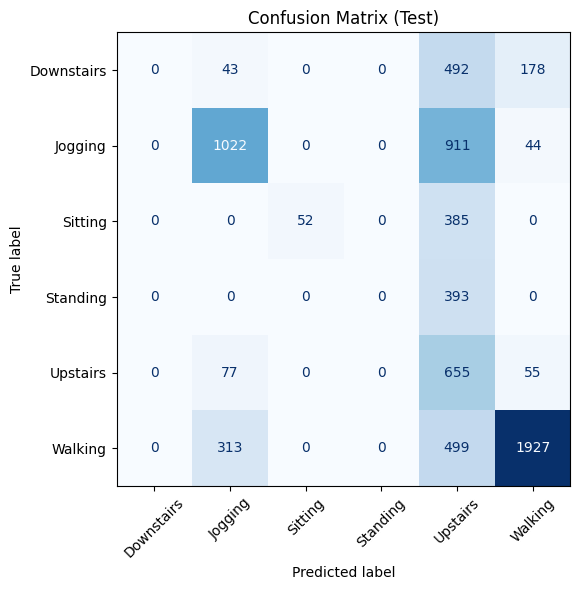

In [ ]:
# 평가

test_loss, test_acc = Lmodel.evaluate(x_test, y_test_hot, verbose=0)
print(f"[TEST] loss={test_loss:.4f}  acc={test_acc:.4f}")

y_prob = Lmodel.predict(x_test, verbose=0)
y_pred = y_prob.argmax(axis=1)

print(classification_report(y_test, y_pred, target_names=label_encode.classes_))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(cm, display_labels=label_encode.classes_)
fig, ax = plt.subplots(figsize=(8,6))
disp.plot(xticks_rotation=45, ax=ax, cmap='Blues', colorbar=False)
plt.title('Confusion Matrix (Test)')
plt.tight_layout()
plt.show()